# Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
!pip install wandb
import wandb
from keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout, TimeDistributed, Lambda, Activation, Reshape,
Softmax, Multiply, AdditiveAttention, Concatenate, Add, RepeatVector
import tarfile
import random
from keras.optimizers import RMSprop, Adam, SGD
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

from math import log
from numpy import array, argmax
import sklearn

# WANDB Login

In [ ]:
!wandb login
from wandb.keras import WandbCallback
wandb.init(project="Assignment-3", entity="kunal_patil")

# Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!gdown https://drive.google.com/file/d/1NDNWaV_4H-BrDn_2cxll2RvTvsW5prqM/view?usp=sharing
!unzip "/content/hi.zip"

# Data processing

In [ ]:
def extract_data(data):
    input = []
    input_char = []
    target = []
    target_char = []

    for i in data:
        input.append(i)
        a=data[i]
        b=list(i)
        target.append(a)
        input_char = list(set(input_char + b))
        target_char = list(set(target_char + b(a)))

    num_input = len(input_char)
    num_target = len(target_char)

    input_char_map=[]
    for i, char in enumerate(input_char):
      a=(char,i+1)
      input_char_map.append(a)
    input_char_map=dict(input_char_map)

    target_char_map=[]
    for j, c in enumerate(target_char):
      b=(c,j+1)
      target_char_map.append(b)
    input_char_map=dict(input_char_map)

    encoder_seq=[]
    for wr in input:
      encoder_seq.append(len(wr))

    decoder_seq=[]
    for wr in target:
      decoder_seq.append(len(wr))

    enco_len= max(encoder_seq)
    deco_len= max(decoder_seq)

    return input_char, target_char, num_input, num_target, enco_len, deco_len, input_char_map, target_char_map

In [ ]:
def one_hot(data, enco_len, deco_len, num_input, num_target):
    L = len(data.keys())
    target = ["\t"+data[i]+"\n" for i in data]
    input = [j for j in data]

    enco_in_arr = np.zeros((L, enco_len, num_input + 1))
    deco_in_arr = np.zeros((L, deco_len, num_target + 1))
    deco_out_arr = deco_in_arr

    for i in range(L):
        in = input[i]
        tar = target[i]

        for j, ch in enumerate(in):
            enco_in_arr[i, j, input_char_map[ch]] = 1.0

    return input, target, enco_in_arr, deco_in_arr, deco_out_arr

In [ ]:
input_char,num_input, input_char_map, num_target, enco_len, deco_len,target_char, target_char_map = extract_data(training_map)


Number of unique input characters: 26
Number of unique output characters: 64

Maximum sequence length for the input: 20
Maximum sequence length for the output: 21


In [ ]:
pad_deco_in_arr = tensorflow.keras.preprocessing.sequence.pad_sequences(deco_in_arr, maxlen=max_deco_seqlength)
pad_deco_out_arr = tensorflow.keras.preprocessing.sequence.pad_sequences(deco_out_arr, maxlen=max_deco_seqlength)
pad_enco_in_arr = tensorflow.keras.preprocessing.sequence.pad_sequences(enco_in_arr, maxlen=max_enco_seqlength)

pad_val_enco_in_arr = tensorflow.keras.preprocessing.sequence.pad_sequences(val_enco_in_arr, maxlen=enco_len)
pad_val_deco_in_arr = tensorflow.keras.preprocessing.sequence.pad_sequences(val_deco_in_arr, maxlen=deco_len)
pad_val_deco_out_arr = tensorflow.keras.preprocessing.sequence.pad_sequences(val_deco_out_arr, maxlen=deco_len)

pad_deco_out_arr_a = np.zeros((pad_deco_out_arr.shape[0], deco_len, tar))
for i,j in enumerate(pad_deco_out_arr.shape[0],deco_len):
  pad_deco_out_arr_a[i][j][pad_deco_out_arr[i][j]] = 1.0

pad_val_deco_out_arr_oh = np.zeros((pad_val_deco_out_arr.shape[0], deco_len, tar))
for i,j in enumerate(pad_val_deco_out_arr.shape[0],deco_len):
  pad_val_deco_out_arr_a[i][j][pad_val_deco_out_arr[i][j]] = 1.0

find an embedding using the Embedding layer


In [ ]:
deco_in_arr = np.argmax(deco_in_arr)
test_deco_in_arr = np.argmax(test_deco_in_arr)
val_deco_in_arr = np.argmax(val_deco_in_arr)

enco_in_arr = np.argmax(enco_in_arr)
test_enco_in_arr = np.argmax(test_enco_in_arr)
val_enco_in_arr = np.argmax(val_enco_in_arr)

# Define functions

In [ ]:
def def_model(cell_type, num_encoder_layers, num_decoder_layers, input_embedding_size, drop_out_ratio, beam_size):

    enco_input = keras.Input(shape=(None, ))
    enco_embed = keras.layers.Embedding(num_input, embedding_size)(enco_input)

    encoder_states = list()
    for j in range(len(enc_latent_dims)):
        if cell_type == "SimpleRNN":
            encoder_outputs, state = keras.layers.SimpleRNN(enc_latent_dims[j], dropout = drop_out_ratio, return_state = True, return_sequences = True)(encoder_outputs)
            encoder_states = [state]
        if cell_type == "LSTM":
            encoder_outputs, state_h, state_c = keras.layers.LSTM(enc_latent_dims[j], dropout = drop_out_ratio, return_state = True, return_sequences = True)(encoder_outputs)
            encoder_states = [state_h,state_c]
        if cell_type == "GRU":
            encoder_outputs, state = keras.layers.GRU(enc_latent_dims[j], dropout = drop_out_ratio, return_state = True, return_sequences = True)(encoder_outputs)
            encoder_states = [state]


    ## DECODER
    deco_input = keras.Input(shape=(None, ))
    deco_embed = keras.layers.Embedding(num_target , embedding_size)(deco_input)


    for j in range(len(enc_latent_dims)):
        if cell_type == "SimpleRNN":
            decoder_outputs, state = keras.layers.SimpleRNN(enc_latent_dims[j], dropout = drop_out_ratio, return_state = True, return_sequences = True)(encoder_outputs)
            decoder_states = [state]
        if cell_type == "LSTM":
            decoder_outputs, state_h, state_c = keras.layers.LSTM(enc_latent_dims[j], dropout = drop_out_ratio, return_state = True, return_sequences = True)(encoder_outputs)
            decoder_states = [state_h,state_c]
        if cell_type == "GRU":
            decoder_outputs, state = keras.layers.GRU(enc_latent_dims[j], dropout = drop_out_ratio, return_state = True, return_sequences = True)(encoder_outputs)
            decoder_states = [state]

    decoder_dense = keras.layers.Dense(num_target, activation="softmax")
    model = keras.Model([enco_input, deco_input], decoder_dense(decoder_outputs))

    return model

In [ ]:
def infer_lstm(num_cell):
    h_enco, c_enco = layer.output

    enco_model = keras.Model(enco_inp, [h_enco, c_enco])

    # Input to the decoder
    deco_inputs = model.input[1]
    deco_embed_layer  = model.layers

    deco_in_state = [keras.Input(shape=(num_cells))]

    deco_outputs, state_h_dec, state_c_dec = deco_lstm(deco_embed(deco_inputs))
    deco_states = [state_h_dec, state_c_dec]

    deco_model = keras.Model([deco_inputs] + deco_in_phase, [decoder_dense(decoder_output)] + deco_state)

    return enco_model, deco_model


def trans_lstm(input):
        out-num = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        sample = np.argmax(out_num[-1, :])

        tar_seq = np.zeros((batch_size))

        while ch,i in (char_index):
            deco_w[i] = deco_w[i] + char_map[i_index]
            tar_seq[i, 0, i_index] = 1.0

        tar_seq = np.argmax(tar_seq)
    return tar_seq

# Train with wandb

In [ ]:
def train_wandb():
    defaults = dict(
    cell_type = "LSTM",
    embedding_size = 64,
    hidden_layer_size = 128,
    num_encoder_layers = 1,
    batch_size = 64,
    num_decoder_layers = 1,
    drop_out_ratio = 0,
    epochs = 10,
    optimizer = 'rmsprop',
    )
    config = wandb.config

    hyperparameters = {
    "embedding_size" : config.embedding_size,
    "num_encoder_layers" : config.num_encoder_layers,
    "num_decoder_layers" : config.num_decoder_layers,
    "hidden_layer_size" : config.hidden_layer_size,
    "cell_type" : config.cell_type,
    "drop_out_ratio": config.drop_out_ratio,
    "in_char_size": len(english_alpha2index),
    "out_char_size": len(hindi_alpha2index),
    "input_len": 25,
    }
    

    model = def_model(num_cells, cell_type, layers, embedding_size, drop_out_ratio)

    f = "infer_model" + str(layers)

    enco_model, deco_model = globals()[f](model, cells)

    val_infe_acc = np.mean(np.array(outputs) == np.array(ground_truths))
    print("Validation accuracy= {} %".format(val_infe_acc*100.0))
    run = "cell_{}_layer_{}_emb_{}_dp_{}_bm_{}".format(cell, layers, embed_size, drop_out_ratio, size_of_beam)
    print(run)

    wandb.run.finish()

In [ ]:
'''sweep_config = {
    'method' : 'bayes',
    'metric' : {
        'name' : 'word_acc',
        'goal' : 'maximize'
    },
    'parameters': {
        'embedding_size': {
            'values': [64,128,96]
        },
        'num_encoder_layers': {
            'values': [1,2,3]
        },
        'num_decoder_layers': {
            'values': [1,2,3]
        },
        'hidden_layer_size': {
            'values': [64,128,256]
        },
        'cell_type' : {
            'values': ['LSTM','GRU','SimpleRNN']  
        },
        
        'drop_out_ratio': {
            'values': [0,0.2,0.4]
        },
        'batch_size': {
            'values': [64]
        },
        'epochs': {
            'values': [25]
        },
        'optimizer':{
            'values': ['adam','rmsprop']
        }
        
    }
}

sweep_id = wandb.sweep(sweep_config, project="Assignment-3", entity="kunal_patil")
wandb.agent(sweep_id, train_wandb)'''

'# Sweep configuration\nsweep_config = {\n  "name": "Assignment3_new",\n  "metric": {\n      "name":"val_accuracy",\n      "goal": "maximize"\n  },\n  "method": "random",\n  "parameters": {\n        "cell_type": {\n            "values": ["LSTM", "RNN", "GRU"]\n        },\n        "num_cells": {\n            "values": [16, 32, 64]\n        },\n        "num_layers": {\n            "values": [1, 2, 3]\n        },\n        "input_embedding_size": {\n            "values": [16, 32, 64]\n        },\n        "dropout_fraction": {\n            "values": [0]\n        },\n        "beam_size": {\n            "values": [1, 3]\n        }\n    }\n}\n\n# Generates a sweep id\nsweep_id = wandb.sweep(sweep_config, project="Assignment-3", entity="kunal_patil")\nprint(f"Sweep ID = {sweep_id}")\nwandb.agent(sweep_id, train_with_wandb, count=100)'

# Training the Best Model

In [ ]:
def train(num_cells, cell_type, layers, embed_size, drop_out_ratio):
    model = def_model(num_cells, cell_type, layers, embed_size, drop_out_ratio)

    history = model.fit(
            [enco_in_arr, deco_in_arr],
            deco_out_arr,
            batch_size = 64,
            epochs = 20,
            verbose = 2
            )

    model.save("best_model.h5")

    f = "infer_model" + str(layers)

    enco_model, deco_model = globals()[f](model, cells)

    val_infe_acc = np.mean(np.array(outputs) == np.array(ground_truths))

    
    plt.plot(history.history["val_accuracy"])
    plt.plot(history.history["accuracy"])
    plt.title("Accuracy vs epoch")
    plt.show()

    plt.plot(history.history["val_loss"])
    plt.plot(history.history["loss"])
    plt.title("Loss vs epoch")
    plt.show()

    return model

# Training with the Best Hyperparameters

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EncoderInput (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 DecoderInput (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 EncoderInputEmbedding (Embeddi  (None, None, 32)    864         ['EncoderInput[0][0]']           
 ng)                                                                                              
                                                                                                  
 DecoderInputEmbedding (Embeddi  (None, None, 64)    4160        ['DecoderInput[0][0]']       

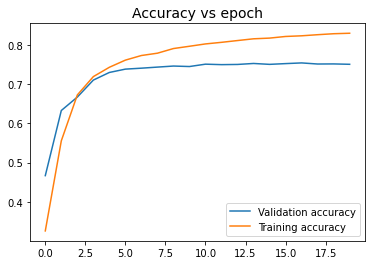

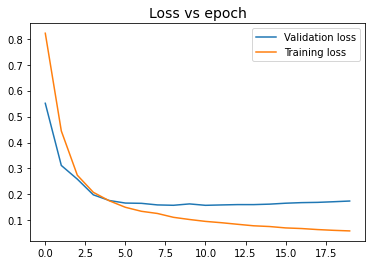

In [ ]:
num_cells = 256
cell_type = "GRU"
num_layers = 2
embedding_size = 32
drop_out_ratio = 0.1
num_encoder_layers = num_layers
num_decoder_layers = num_layers

model, history = train(num_cells, cell_type, layers, embedding_size, drop_out_ratio)

Load the best model

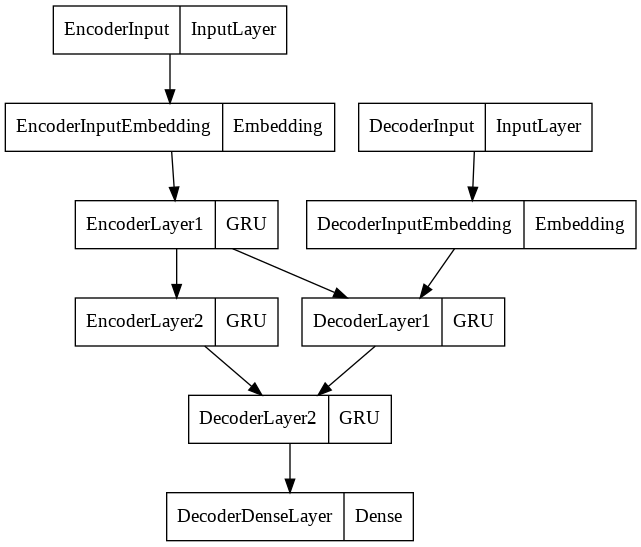

In [ ]:
keras.utils.plot_model(model)

In [ ]:
train = model.evaluate([enco_in_arr, deco_in_arr], deco_out_arr)
val = model.evaluate([val_enco_in_arr, val_deco_in_arr], val_deco_out_arr)
test = model.evaluate([test_enco_in_arr, test_deco_in_arr], test_deco_out_arr)

train=train*100
test=test*100
val=val*100

print("Character-wise training accuracy = {} %".format(train))
print("Character-wise validation accuracy = {} %".format(val))
print("Character-wise test accuracy = {} %".format(test))

139/139 [==============================] - 6s 42ms/step - loss: 0.1742 - accuracy: 0.7483
Character-wise training accuracy = 86.0349178314209 %
Character-wise validation accuracy = 75.10246634483337 %
Character-wise test accuracy = 74.83358383178711 %


In [ ]:
outputs = []

if not os.path.exists('Test_Prediction'):
  os.mkdir('Test_Prediction')

with open('Test_Prediction.npy', 'wb') as f:
  np.save(f)
df_test.to_csv("Test_Prediction.csv", index=False)
 
print("Test set infer accuracy based on whole string matching = {} %".format((np.mean(np.array(outputs) == np.array(ground_truths)))*100.0))

Test set Inference accuracy based on whole string matching = 36.71769473210266 %


In [ ]:
df_test = pd.read_csv("Test_Prediction.csv")
df_test.head(25)

,Input,Ground Truth,Model output
2566,fulay,फुलाए,फूलाय
3501,lakshy,लक्ष्य,लक्ष्य
3766,weeks,वीक्स,वीक्स
4396,halchaal,हालचाल,हलचल
2386,packard,पैकर्ड,पैकार्ड
270,aagaashe,आगाशे,आगाशाए
3628,vansh,वंश,वांश
1568,dit,डिट,दीत
3155,muflisi,मुफलिसी,मुफलीसी
1425,jaine,जैने,जाइने
